In [2]:
import torch as th 
import numpy as np 
from torch import nn 
from coronaryx.utils import read_dataset
from pathlib import Path 

In [3]:
# source: https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/08-deep-autoencoders.html
class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU):
        """
        Args:
           num_input_channels : Number of input channels of the image
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2),  # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 8x8 => 4x4
            act_fn(),
            nn.Flatten(),  # Image grid to single feature vector
            nn.Linear(2 * 16 * c_hid, latent_dim),
        )

    def forward(self, x):
        return self.net(x)
    
class Decoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU):
        """
        Args:
           num_input_channels : Number of channels of the image to reconstruct
           base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(nn.Linear(latent_dim, 2 * 16 * c_hid), act_fn())
        self.net = nn.Sequential(
            nn.ConvTranspose2d(
                2 * c_hid, 2 * c_hid, kernel_size=3, output_padding=1, padding=1, stride=2
            ),  # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),  # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(
                c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2
            ),  # 16x16 => 32x32
            nn.Tanh(),  # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

In [4]:
import pytorch_lightning as pl 
import torch.optim as optim
import torch.nn.functional as F

class Autoencoder(pl.LightningModule):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 1,
        width: int = 32,
        height: int = 32,
    ):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = th.zeros(2, num_input_channels, width, height)

    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        """Given a batch of images, this function returns the reconstruction loss (MSE in our case)"""
        x, _ = batch  # We do not need the labels
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=20, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("test_loss", loss)

In [5]:
e = Autoencoder(32, 32, Encoder, Decoder, 1, 32, 32)
e(th.randn(1, 1, 32, 32)).shape

torch.Size([1, 1, 32, 32])

In [7]:
# split dataset to train/val 
from coronaryx.utils import save_dataset, train_dev_test_split

train_dataset, dev_dataset, _ = train_dev_test_split(dataset, 0.15, 0)
train_dir = "../revised-train"
test_dir = "../revised-test"
save_dataset(train_dataset, train_dir)
save_dataset(dev_dataset, test_dir)

In [ ]:
from cadml.datamodules.roi_classification import ROIClassificationDataset, ROIClassificationDataModule
from omegaconf import OmegaConf
import hydra 
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf

cfg_path = "../cadml/conf"
print(cfg_path)
with initialize(version_base=None, config_path=cfg_path):
    cfg = compose(config_name="config")

cfg.datamodule.train_dir = train_dir
cfg.datamodule.val_dir = test_dir
cfg.datamodule.test_dir = test_dir

# Train autoencoder

In [10]:
cfg

{'datamodule': {'name': 'roi-classification', 'train_batch_size': 128, 'val_batch_size': 128, 'test_batch_size': 128, 'predict_batch_size': 128, 'train_dir': '../revised-train', 'val_dir': '../revised-test', 'test_dir': '../revised-test', 'predict_dir': 'data', 'upsample_positive_examples': True, 'allow_padding': False, 'apply_segmentation_mask': False, 'roi_size': 32}, 'model': {'name': 'simple-cnn', 'in_channels': 1, 'checkpoint_path': None}, 'task': {'name': 'roi-classification', 'accelerator': 'gpu', 'devices': 1, 'positive_class_weight': 1.0, 'learning_rate': 0.001, 'weight_decay': 0.01, 'momentum': 0.9, 'nesterov': False, 'max_epochs': 200, 'decision_threshold': 0.5}, 'stage': 'train', 'seed': 0}

In [17]:
import torchvision.transforms as tvt
from torch.utils.data import TensorDataset, DataLoader
import coronaryx.algorithms as cxa

DEVICE = "mps"

def get_tensor_dataset(data_dir):
    dataset = read_dataset(data_dir)
    branches = [
        branch
        for scan in dataset
        for branch in cxa.split_into_branches(scan)
    ]
    dataset = ROIClassificationDataset(branches)
    dataset_len = len(dataset)
    dataset = [(dataset[i][0], dataset[i][1]) for i in range(dataset_len)]
    
    x, y = zip(*dataset)
    x = th.stack(x).to(DEVICE)
    y = th.tensor(y).to(DEVICE)
    return TensorDataset(x, y)

train_tensor = get_tensor_dataset(train_dir)
val_tensor = get_tensor_dataset(test_dir)

train_loader = DataLoader(train_tensor, batch_size=32, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=32, shuffle=True)

In [ ]:
# data_module = ROIClassificationDataModule(cfg)


# dataset = ROIClassificationDataset(cfg.datamodule.train_dir)
# data_module.setup()
# train_loader = data_module.train_dataloader()
# val_loader = data_module.val_dataloader()
# test_loader = data_module.test_dataloader()
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from cadml.callbacks import MetricsLoggingCallback


wandb_logger = WandbLogger(project="cad-ml", entity="goader")
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    save_top_k=3,
    monitor="val_loss",
    mode="min",
    dirpath="output/",
    filename=f"cad-autoencoder-{wandb_logger.experiment.name}-{{epoch:03d}}-{{val_loss:.4f}}",
)
trainer = pl.Trainer(
    accelerator="mps",
    logger=wandb_logger,
    max_epochs=200,
    devices=1,
    # default_root_dir='output',
    callbacks=[checkpoint_callback],
    # fast_dev_run=True,
    # overfit_batches=10,
    # profiler='simple',
)
# if no checkpoint_path is passed, then it is None, thus the model will start from the very beginning

ae = Autoencoder(32, 32, Encoder, Decoder, 1, 32, 32)
trainer.fit(ae, train_dataloaders=train_loader, val_dataloaders=val_loader)

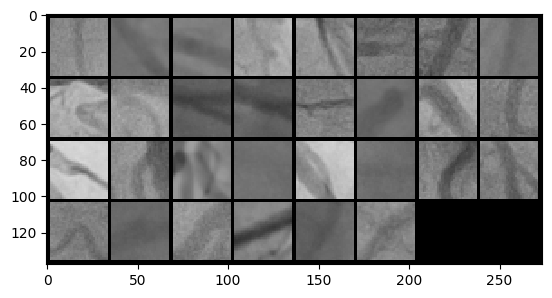

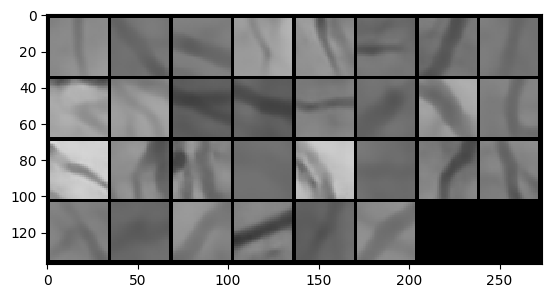

In [40]:
# sample images from validation set and display reconstructions 
import matplotlib.pyplot as plt
import torchvision.transforms as tvt
from torchvision.utils import make_grid

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def show_batch(batch):
    show(make_grid(batch))

def show_reconstructions(model, loader, num_images=10):
    model.eval()
    images, _ = next(iter(loader))
    images = images[:num_images]
    reconstructions = model(images).detach().cpu()
    show_batch(images.cpu())
    plt.show()
    show_batch(reconstructions)
    plt.show()

show_reconstructions(ae, val_loader, 30)

# classify rois features

In [32]:
characteristics = {
    "totalOcclusion",
    "thrombus",
    'severeTortuosity',
    'heavyCalicified'
}

In [43]:
from collections import Counter, defaultdict
dataset = read_dataset("../revised-dataset")

c = Counter()
values = defaultdict(set)
all_count = 0
for scan in dataset:
    for roi in scan.rois:
        all_count += 1
        for k, v in roi.form.items():
            if k not in characteristics:
                continue 
            c.update([k])
            if isinstance(v, list):
                values[k].update(v)
            else:
                values[k].add(v)
display(c)
display(values)

Counter({'heavyCalicified': 14,
         'thrombus': 1,
         'severeTortuosity': 6,
         'totalOcclusion': 15})

defaultdict(set,
            {'heavyCalicified': {True},
             'thrombus': {True},
             'severeTortuosity': {True},
             'totalOcclusion': {True}})

In [35]:
all_count

220

In [48]:
from coronaryx.data import CoronagraphyScan, ROI

def get_rois_with_characteristics(scans: list[CoronagraphyScan], characteristics: set[str], size: int=32) -> tuple[np.ndarray, np.ndarray]:
    rois = []
    labels = []
    sorted_characteristics = sorted(list(characteristics))
    for scan in scans:
        for branch in cxa.split_into_branches(scan):
            for anchor in cxa.traverse_branch_nodes(branch):
                overlapping_roi = next((roi for roi in scan.rois if anchor in roi), None)
                if not overlapping_roi:
                    continue
                crop = branch.scan.crop_at(anchor, size)
                
                # get crop characteristics
                crop_labels = []
                for ch in sorted_characteristics:
                    # characteristic is 1 if the key exist and is ==True 
                    l = overlapping_roi.form.get(ch, False)
                    if not isinstance(l, bool):
                        raise ValueError(f"characteristic {ch} is not boolean but {type(l)}")
                    crop_labels.append(int(l))
                rois.append(crop)
                labels.append(crop_labels)
    rois = np.array(rois, dtype=np.float32)
    labels = np.array(labels, dtype=np.byte)
    return rois, labels

print(sorted(list(characteristics)))
rois, labels = get_rois_with_characteristics(dataset, characteristics, 32)
print(rois.shape, labels.shape)
print(labels.sum(axis=0))

['heavyCalicified', 'severeTortuosity', 'thrombus', 'totalOcclusion']
(3208, 32, 32)                                                              (3208, 4)
[210 126  18 225]


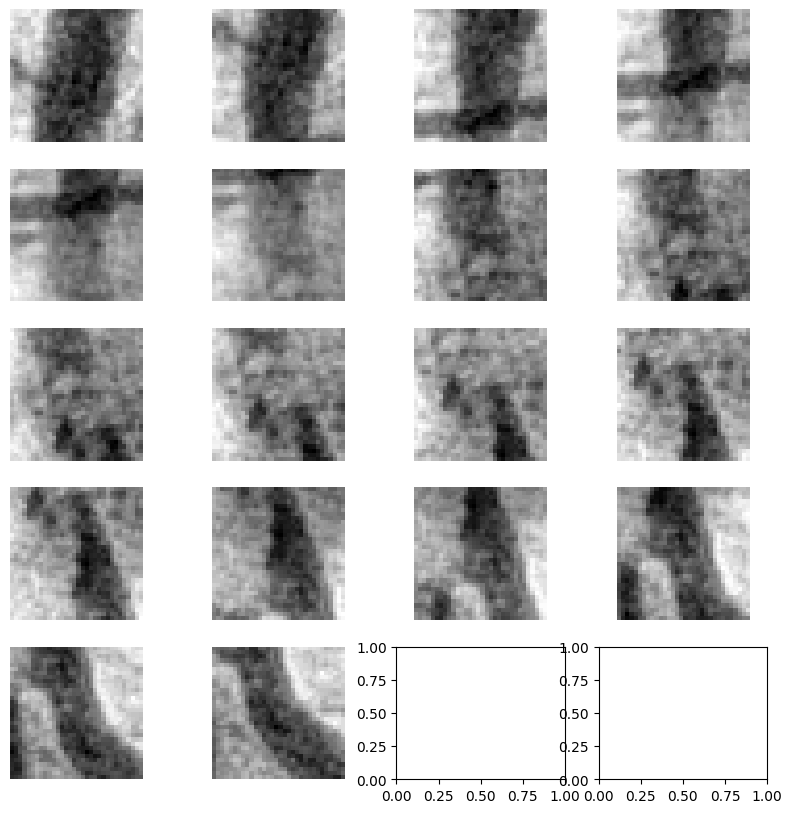

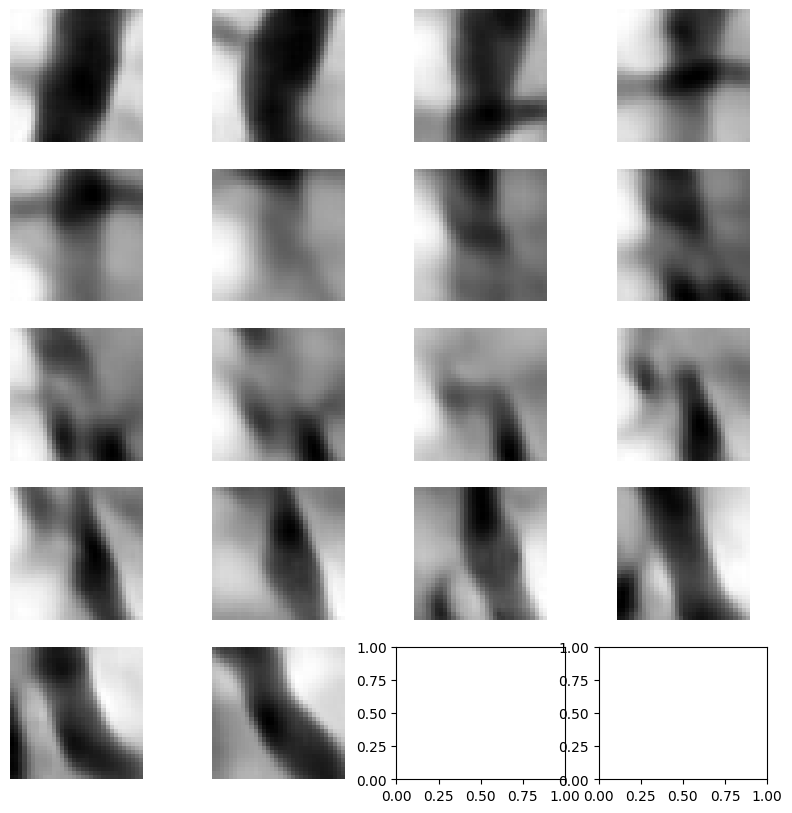

In [72]:
thrombus_rois = rois[labels[:, 2] == 1]
# display rois in grid 
fig, axs = plt.subplots(5, 4, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    if i >= len(thrombus_rois):
        break
    ax.imshow(thrombus_rois[i], cmap="gray")
    ax.axis("off")
plt.show()

fig, axs = plt.subplots(5, 4, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    if i >= len(thrombus_rois):
        break
    roi = thrombus_rois[i] / 255.0
    roi_th = tvt.ToTensor()(roi).to(DEVICE).reshape(1, 1, 32, 32)
    ax.imshow(ae(roi_th).reshape(32, 32).detach().cpu(), cmap="gray")
    ax.axis("off")
plt.show()

## Build classifiers

RandomForestClassifier(max_depth=5)
heavyCalicified: mean f1 score=0.009
severeTortuosity: mean f1 score=0.000
thrombus: mean f1 score=0.000
totalOcclusion: mean f1 score=0.000

DecisionTreeClassifier(max_depth=5)
heavyCalicified: mean f1 score=0.035
severeTortuosity: mean f1 score=0.055
thrombus: mean f1 score=0.000
totalOcclusion: mean f1 score=0.146

SVC(C=0.025, kernel='linear')
heavyCalicified: mean f1 score=0.000
severeTortuosity: mean f1 score=0.000
thrombus: mean f1 score=0.000
totalOcclusion: mean f1 score=0.000

SVC(C=1, gamma=2)
heavyCalicified: mean f1 score=0.055
severeTortuosity: mean f1 score=0.031
thrombus: mean f1 score=0.000
totalOcclusion: mean f1 score=0.240



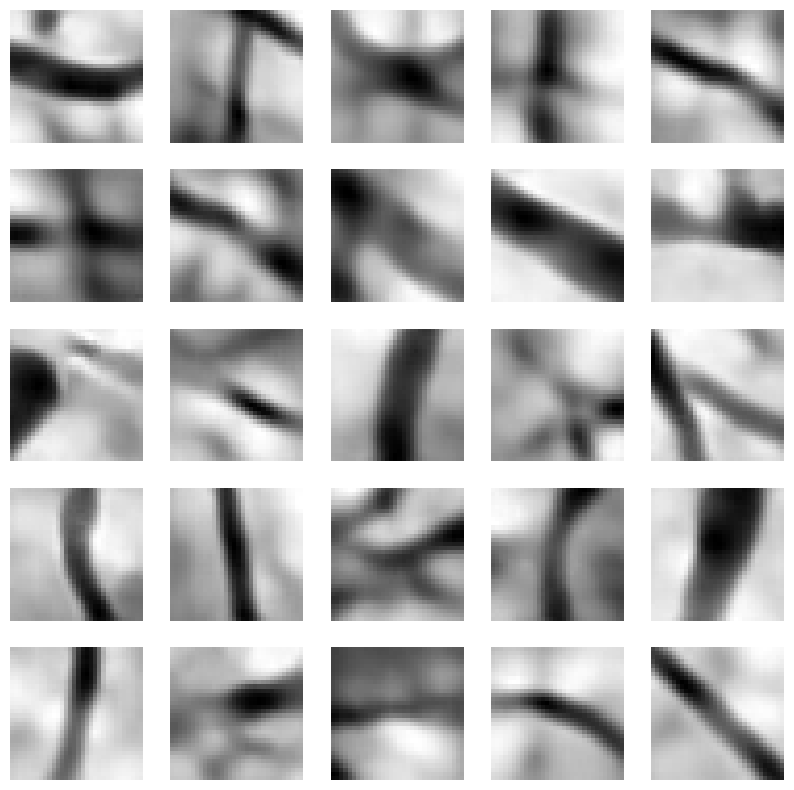

In [74]:
# build random forest classifier for each label separately
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import torchvision.transforms.functional as tvf 

chkpt_path = "output/cad-autoencoder-misunderstood-snowball-2733-epoch=083-val_loss=0.4206.ckpt"
ae_from_checkpoint = Autoencoder.load_from_checkpoint(chkpt_path).to(DEVICE)

th_rois = th.stack([tvf.to_tensor(roi / 255.0) for roi in rois]).to(DEVICE)
encoder = ae_from_checkpoint.encoder
X = encoder(th_rois).detach().cpu().numpy()

# print sample reconstructions 
reco = ae_from_checkpoint.decoder(th.Tensor(X).to(DEVICE)).detach().cpu().numpy()
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    if i >= len(reco):
        break
    sample_i = np.random.randint(0, len(reco))
    ax.imshow(reco[sample_i].reshape(32, 32), cmap="gray")
    ax.axis("off")



def chellenge_classifier(X, labels, characteristics, clf):
    for ch in sorted(list(characteristics)):
        y = labels[:, sorted(list(characteristics)).index(ch)]
        xvalidation_scores = cross_val_score(clf, X, y, cv=5, scoring="f1")
        print(f"{ch}: mean f1 score={xvalidation_scores.mean():.3f}")

classifiers = [
    RandomForestClassifier(n_estimators=100, max_depth=5),
    DecisionTreeClassifier(max_depth=5),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
]

for clf in classifiers:
    print(clf)
    chellenge_classifier(X, labels, characteristics, clf)
    print()
